<a href="https://colab.research.google.com/github/mukul-mschauhan/Machine-Learning-Projects/blob/master/MNIST_CNN_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN from Scratch (Functions Only) — MNIST (PyTorch)

This notebook walks you through a **minimal CNN** for MNIST using **only functions** (no `nn.Module` classes).

You will see:
- **Input data** (MNIST images)
- **Convolution** with **padding** and **stride**
- **Max pooling** for downsampling
- **Flatten + Feedforward (Linear) layer** for classification
- **Backpropagation** and how **accuracy improves across epochs**


In [1]:
# Cell 1: Imports
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# For reproducibility (optional but helpful for beginners)
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1) Load MNIST as Tensors

MNIST images are:
- **Grayscale** (1 channel)
- Size **28×28**
- Labels **0–9**

We use `ToTensor()` so pixels become floats in `[0,1]`.


In [2]:
# Cell 2: Data loaders
def get_loaders(batch_size=64):
    tfm = transforms.ToTensor() # converts raw images into tensors
    train_ds = datasets.MNIST(root=".", train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST(root=".", train=False, download=True, transform=tfm)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) # DataLoader groups images into small piles called Batches
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = get_loaders(batch_size=64)

# Peek one batch to understand shapes
x, y = next(iter(train_loader))
print("x shape:", x.shape)  # (batch, channels, height, width)
print("y shape:", y.shape)  # (batch,)
print("First 10 labels:", y[:10].tolist())

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 641kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


x shape: torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])
First 10 labels: [1, 2, 8, 5, 2, 6, 9, 9, 9, 4]


## 2) Initialize Parameters (Weights/Biases)

We create tensors directly:
- **Conv weights** `Wc` shaped `(out_channels, in_channels, kH, kW)`
- **Conv bias** `bc` shaped `(out_channels,)`

This layer acts as the "Feature Detector.
- **Wc (Weights):** Shape (8, 1, 3, 3).
- **8:** The number of filters (detectives).
- **1:** The number of input channels (Grayscale MNIST images).
- **3, 3:** The Kernel Size (\(3\times 3\) window).
- **bc (Bias):** Shape (8). One "offset" value for each of the 8 filters.

- **Scaling (0.1):** Multiplying by 0.1 prevents the initial random numbers from being too large, which helps the model learn faster (stable gradients).

Then a **Fully Connected (Linear)** layer:
- After conv+pool: `8×14×14 = 1568` features
- Map `1568 → 10` classes


In [4]:
# Cell 3: Parameters (no classes)
def init_params(device):
    # Conv: out=8, in=1, kernel=3x3
    Wc = torch.randn(8, 1, 3, 3, device=device) * 0.1
    bc = torch.zeros(8, device=device) # 8 filters for edge detection, shape detection etc

    # FC: input=8*14*14=1568, output=10
    Wf = torch.randn(1568, 10, device=device) * 0.1
    bf = torch.zeros(10, device=device)

    # Enable gradients so backprop can compute them
    for p in [Wc, bc, Wf, bf]:
        p.requires_grad_(True)

    return {"Wc": Wc, "bc": bc, "Wf": Wf, "bf": bf}

P = init_params(device)
{k: v.shape for k, v in P.items()}

{'Wc': torch.Size([8, 1, 3, 3]),
 'bc': torch.Size([8]),
 'Wf': torch.Size([1568, 10]),
 'bf': torch.Size([10])}

## 3) Forward Pass (CNN)

### What happens to shapes?

Input `x`: `(B, 1, 28, 28)`

1) **Conv2D**: `kernel=3×3`, `stride=1`, `padding=1`
- Padding=1 keeps spatial size **28×28**
- Output becomes `(B, 8, 28, 28)`

2) **ReLU**: same shape

3) **MaxPool 2×2** with stride 2
- Shrinks `28→14`
- Output `(B, 8, 14, 14)`

4) **Flatten**
- `(B, 8*14*14) = (B, 1568)`

5) **Linear**
- `(B, 1568) → (B, 10)` logits


In [5]:
# Cell 4: Forward function (Conv -> ReLU -> Pool -> Flatten -> Linear)
def forward(x, P):
    # Convolution:
    # - stride=1: kernel moves 1 pixel at a time
    # - padding=1: add a 1-pixel border so 28x28 stays 28x28 for a 3x3 kernel
    x = F.conv2d(x, P["Wc"], P["bc"], stride=1, padding=1)  # (B,8,28,28)
    x = F.relu(x)

    # Max pooling:
    # - kernel=2, stride=2 halves height & width: 28->14
    x = F.max_pool2d(x, kernel_size=2, stride=2)            # (B,8,14,14)

    # Flatten
    x = x.view(x.size(0), -1)                               # (B,1568)

    # Fully-connected (feed-forward)
    logits = x @ P["Wf"] + P["bf"]                          # (B,10)
    return logits

# Quick shape check on one mini-batch
xb, yb = next(iter(train_loader))
xb = xb.to(device)
logits = forward(xb, P)
print("logits shape:", logits.shape)


logits shape: torch.Size([64, 10])


### (Optional) Print intermediate shapes for learning

This helps beginners *see* how padding/stride/pooling affect dimensions.


In [6]:
# Cell 5: Shape tracing (optional learning helper)
def forward_with_shapes(x, P):
    print("Input:", x.shape)  # (B,1,28,28)

    x = F.conv2d(x, P["Wc"], P["bc"], stride=1, padding=1)
    print("After conv (stride=1, pad=1):", x.shape)  # (B,8,28,28)

    x = F.relu(x)
    print("After ReLU:", x.shape)

    x = F.max_pool2d(x, kernel_size=2, stride=2)
    print("After maxpool (2x2, stride=2):", x.shape)  # (B,8,14,14)

    x = x.view(x.size(0), -1)
    print("After flatten:", x.shape)  # (B,1568)

    logits = x @ P["Wf"] + P["bf"]
    print("Logits:", logits.shape)    # (B,10)
    return logits

_ = forward_with_shapes(xb[:4], P)  # trace for 4 images


Input: torch.Size([4, 1, 28, 28])
After conv (stride=1, pad=1): torch.Size([4, 8, 28, 28])
After ReLU: torch.Size([4, 8, 28, 28])
After maxpool (2x2, stride=2): torch.Size([4, 8, 14, 14])
After flatten: torch.Size([4, 1568])
Logits: torch.Size([4, 10])


## 4) Accuracy Function

We compute accuracy by:
- Predicting `argmax(logits)`
- Comparing with labels


In [7]:
# Cell 6: Accuracy
@torch.no_grad()
def accuracy(loader, P, device):
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = forward(x, P)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

print("Initial (untrained) test accuracy:", accuracy(test_loader, P, device))

Initial (untrained) test accuracy: 0.0617


## 5) Training Loop (Backpropagation)

For each batch:
1) **Forward** → logits  
2) **Loss** (`cross_entropy`)  
3) `loss.backward()` computes gradients for every parameter  
4) `optimizer.step()` updates weights to reduce loss

We track:
- train accuracy per epoch
- test accuracy per epoch

The magic happens in these three specific lines:
* **opt.zero_grad() (Clear the Slate):** PyTorch remembers mistakes (gradients) from the previous batch. Before looking at new images, we must "empty the trash" so we don't mix old errors with new ones.

* **loss.backward() (The "Blame" Phase):** This is the actual Backpropagation. The computer looks at the loss (the error) and mathematically works backward through the network. It calculates exactly how much each weight (\(W\)) and bias (\(b\)) contributed to that specific mistake.

* **opt.step() (The "Fix" Phase):** Now that the model knows who is to blame, the Optimizer (SGD) nudges the weights in the right direction. It subtracts a tiny bit of the "error" from the weights using the Learning Rate (lr).


In [8]:
# Cell 7: Training (functions only, short)
def train(num_epochs=5, lr=0.1, batch_size=64):
    train_loader, test_loader = get_loaders(batch_size=batch_size)
    P = init_params(device) #

    # Optimizer works directly with tensors too
    opt = torch.optim.SGD(P.values(), lr=lr) # algorithm that turns the wrench to tighten or loosen the weights

    history = {"train_acc": [], "test_acc": [], "loss": []}

    for epoch in range(1, num_epochs + 1):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device) # moving to cpu/gpu for calculation

            logits = forward(x, P) # generates prediction
            loss = F.cross_entropy(logits, y) # calculates loss

            opt.zero_grad() #  Clears out the mistakes from the previous batch
            loss.backward()   # <-- backprop happens here
            opt.step() #  Optimizer updates the weights

        # End of epoch: measure improvement
        tr_acc = accuracy(train_loader, P, device)
        te_acc = accuracy(test_loader, P, device)

        history["train_acc"].append(tr_acc)
        history["test_acc"].append(te_acc)
        history["loss"].append(loss.item())

        print(f"Epoch {epoch:02d} | loss={loss.item():.4f} | train_acc={tr_acc:.4f} | test_acc={te_acc:.4f}")

    return P, history

P_trained, hist = train(num_epochs=5, lr=0.1, batch_size=64)

Epoch 01 | loss=0.3774 | train_acc=0.9043 | test_acc=0.9086
Epoch 02 | loss=0.3077 | train_acc=0.9469 | test_acc=0.9505
Epoch 03 | loss=0.0980 | train_acc=0.9600 | test_acc=0.9616
Epoch 04 | loss=0.0399 | train_acc=0.9697 | test_acc=0.9698
Epoch 05 | loss=0.0225 | train_acc=0.9746 | test_acc=0.9731


## 6) Accuracy improves with epochs (plot)

This plot makes it visually obvious that training improves performance.


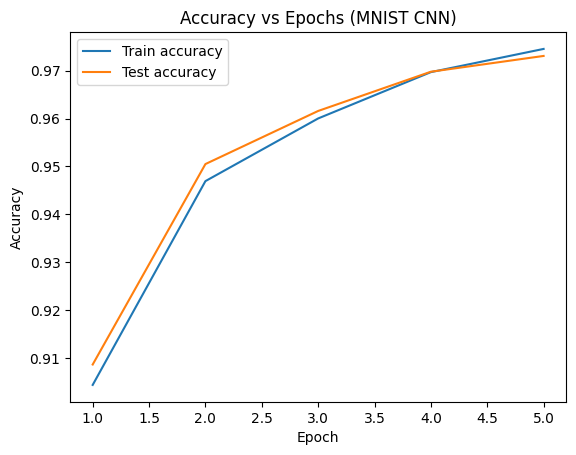

In [9]:
# Cell 8: Plot accuracy vs epochs
epochs = list(range(1, len(hist["train_acc"]) + 1))

plt.figure()
plt.plot(epochs, hist["train_acc"], label="Train accuracy")
plt.plot(epochs, hist["test_acc"], label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs (MNIST CNN)")
plt.legend()
plt.show()

## 7) Try a few predictions (sanity check)

We show a few test images and predictions.


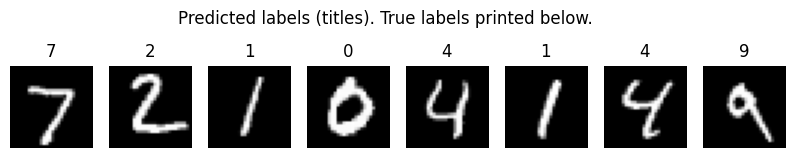

True labels:      [7, 2, 1, 0, 4, 1, 4, 9]
Predicted labels: [7, 2, 1, 0, 4, 1, 4, 9]


In [10]:
# Cell 9: Show a few predictions
@torch.no_grad()
def predict_batch(loader, P, n=8):
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    logits = forward(x, P)
    pred = logits.argmax(dim=1)
    return x[:n].cpu(), y[:n].cpu(), pred[:n].cpu()

imgs, labels, preds = predict_batch(test_loader, P_trained, n=8)

plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(imgs[i].squeeze(0), cmap="gray")
    plt.axis("off")
    plt.title(f"{preds[i].item()}")
plt.suptitle("Predicted labels (titles). True labels printed below.")
plt.show()

print("True labels:     ", labels.tolist())
print("Predicted labels:", preds.tolist())
